In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import Image
from sklearn.decomposition import PCA
import sklearn
from scipy.stats import iqr

In [2]:
data = pd.read_excel('Data/Dataset.xlsx', sheet_name = 'Sheet1')
data.shape

(11565, 34)

### Handling Nulls as numpy.nan

In [3]:
num_missing_data = data.loc[:, data.isnull().any() ].isnull().sum()
num_missing_data

Age             5
DriverRating    6
dtype: int64

The number of missing data rows in the data is relatively small (regarding to the total number of rows). We can simply remove the rows containing missing data but before that let's check if the rows with missing data has made any fraud! the reason I do that is that there are a small number of rows that made fraud and if this rows belong to that group I intend to keep them.

In [4]:
data.loc[data.isnull().any(axis=1),"FraudFound_P"]

14       0
23       0
83       0
2510     0
4659     0
5015     0
7374     0
8522     0
9557     0
10259    0
11178    0
Name: FraudFound_P, dtype: int64

As all belong to not made a fraud, I prefer to delete them to avoid any data corruption. If I wanted to fill these columns, I would suggest the methods below :<br>
Age : the mean of Age column <br>
DriverRating : the mode of DriverRating column

In [5]:
data = data.drop(index = data[data.isnull().any(axis=1)].index)

### Handling nulls with other representatives

Some times, the null values in our data are not entered as np.nan which is recognizable by pandas.According to the unique values exist in the columns (see Part 1 - Data Exploratory) we have other forms of the null values in our data as well.

In [6]:
print( "DayOfWeekClaimed = 0 :")
print(data.loc[data["DayOfWeekClaimed"] == 0].index)
print("-----------------------------------------------------------------------------")
print( "MonthClaimed = 0 :")
print(data.loc[data["MonthClaimed"] == 0].index)
print("-----------------------------------------------------------------------------")
print( "Days_Policy_Accident = none :")
print(data.loc[data["Days_Policy_Accident"] == "none"].index)
print("-----------------------------------------------------------------------------")
print( "Days_Policy_Claim = none :")
print(data.loc[data["Days_Policy_Claim"] == "none"].index)
print("-----------------------------------------------------------------------------")
print( "PastNumberOfClaims = none :")
print(data.loc[data["PastNumberOfClaims"] == "none"].index)
print("-----------------------------------------------------------------------------")
print( "NumberOfSuppliments = none :")
print(data.loc[data["NumberOfSuppliments"] == "none"].index)

DayOfWeekClaimed = 0 :
Int64Index([1146], dtype='int64')
-----------------------------------------------------------------------------
MonthClaimed = 0 :
Int64Index([1146], dtype='int64')
-----------------------------------------------------------------------------
Days_Policy_Accident = none :
Int64Index([  153,   555,   806,   918,   992,  1101,  1523,  1752,  1863,
             2242,  2253,  2328,  2702,  2773,  2892,  3014,  3810,  4645,
             5401,  5651,  5809,  6020,  6171,  6303,  6633,  6701,  6980,
             7040,  7080,  7525,  7866,  9161,  9730, 10005, 10101, 10653,
            11112, 11365, 11550],
           dtype='int64')
-----------------------------------------------------------------------------
Days_Policy_Claim = none :
Int64Index([1146], dtype='int64')
-----------------------------------------------------------------------------
PastNumberOfClaims = none :
Int64Index([    0,     1,     5,     6,     9,    10,    11,    12,    13,
               19,
     

- **NumberOfSuppliments** and **PastNumberOfClaims** have many rows with category *none*. Here *none* is not a missing data but it is a category that we should take into account. so we don't remove or fill these two faetures.
- The item number **1146** seems to be a faulty entery as it doesn't have sum common varibels (DayOfWeekClaimed ,MonthClaimed and Days_Policy_Claim) and it is the only entery which doen't have them. I check its FraudFound_P feature and they didn't make a fraud so we remove it from the data
- **Days_Policy_Accident** is another column with none values. not many rows have this feature equal to none so we might be tempted to remove or fill these none values. before that lets have a look back on to its pie chart and see what percntage of this value had commited a fraud.

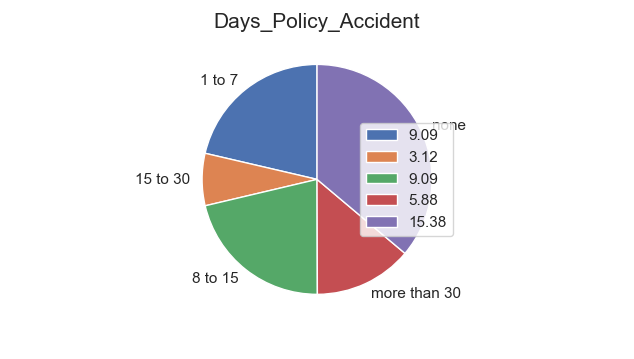

In [7]:
Image("Figures/Part 1/Days_Policy_Accident.png")

it is the category that has the most rate of crime! so we should't fill this value with anything or remove it. we should keep this as a category and use it for making decisions

In [8]:
data = data.drop(index=1146)

In [9]:
data = data.reset_index(drop=True)

### Remove Duplicades

In [10]:
data.duplicated().any()

False

### Handle Outliers

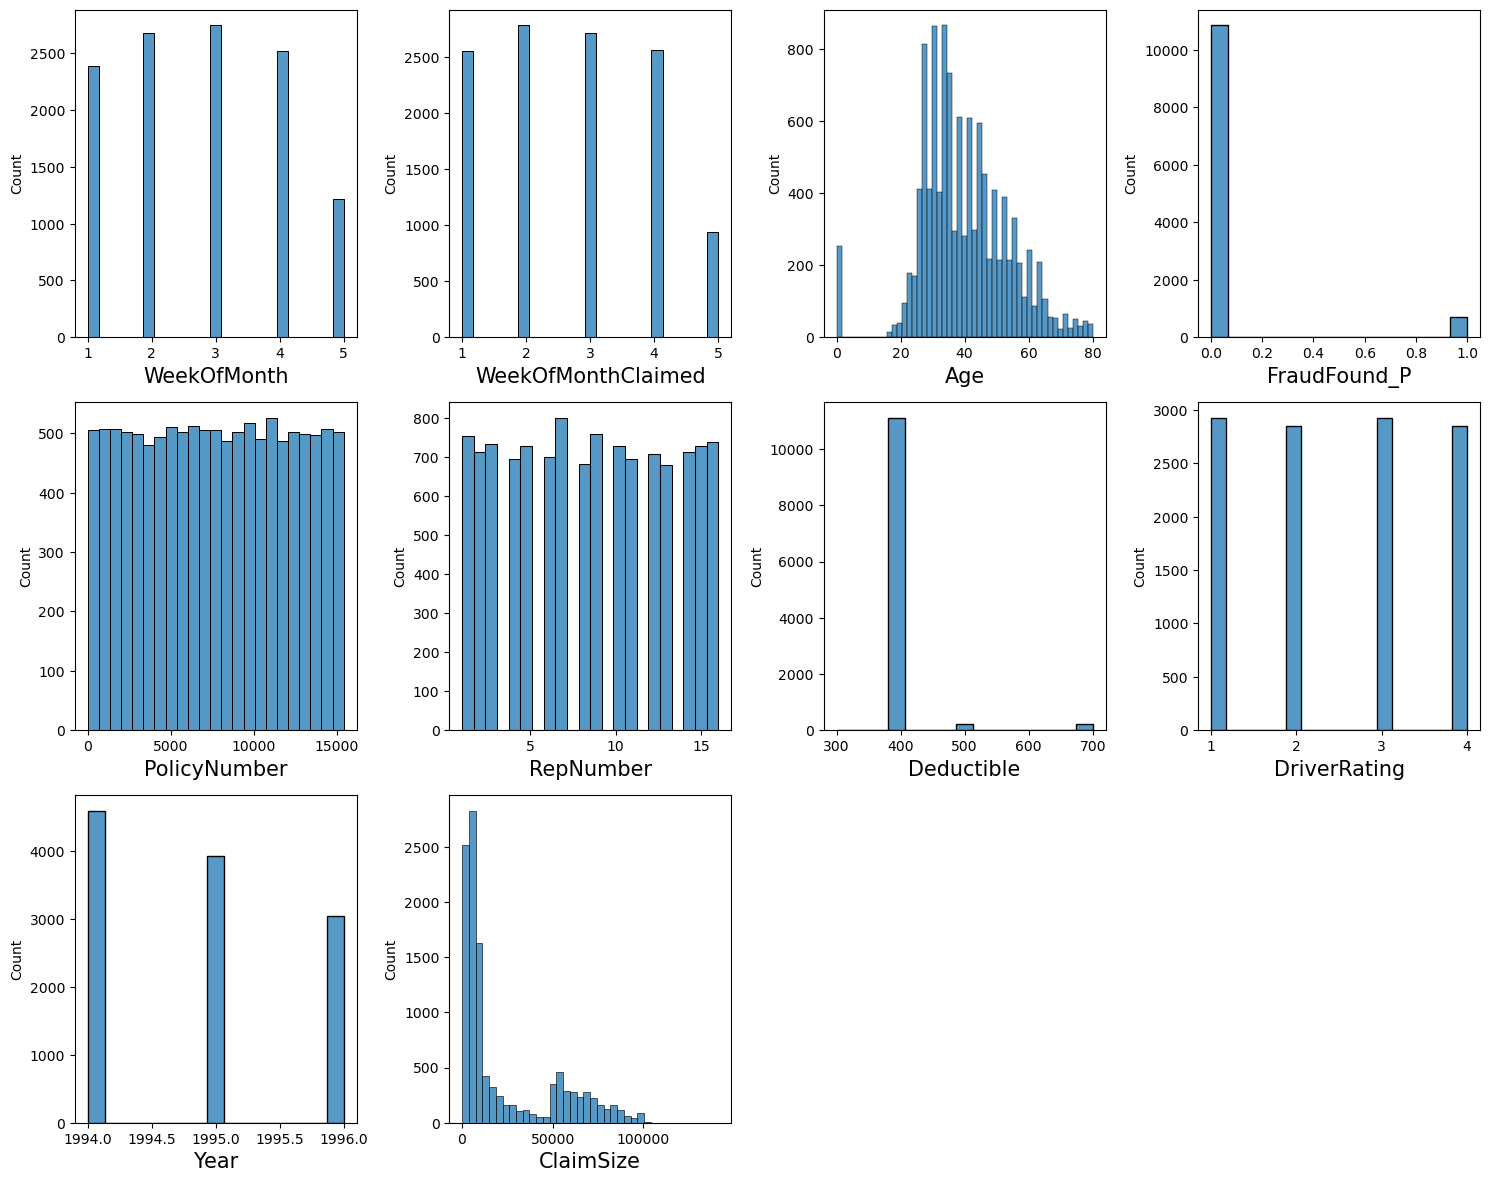

In [11]:
numeric_data = data.select_dtypes(include=['int64', 'float64'])

if not os.path.exists('Figures/Part 2'):
    os.makedirs('Figures/Part 2')
fig = plt.figure(figsize = (15, 35))
plotnumber = 1
for col in numeric_data:
    if plotnumber <= 34:
        ax = plt.subplot(9, 4, plotnumber)
        sns.histplot(data=numeric_data,x=col)
        plt.xlabel(col, fontsize = 15)  
    plotnumber += 1
plt.tight_layout()
plt.show()
fig.savefig('Figures/Part 2/numeric_distributions.png')

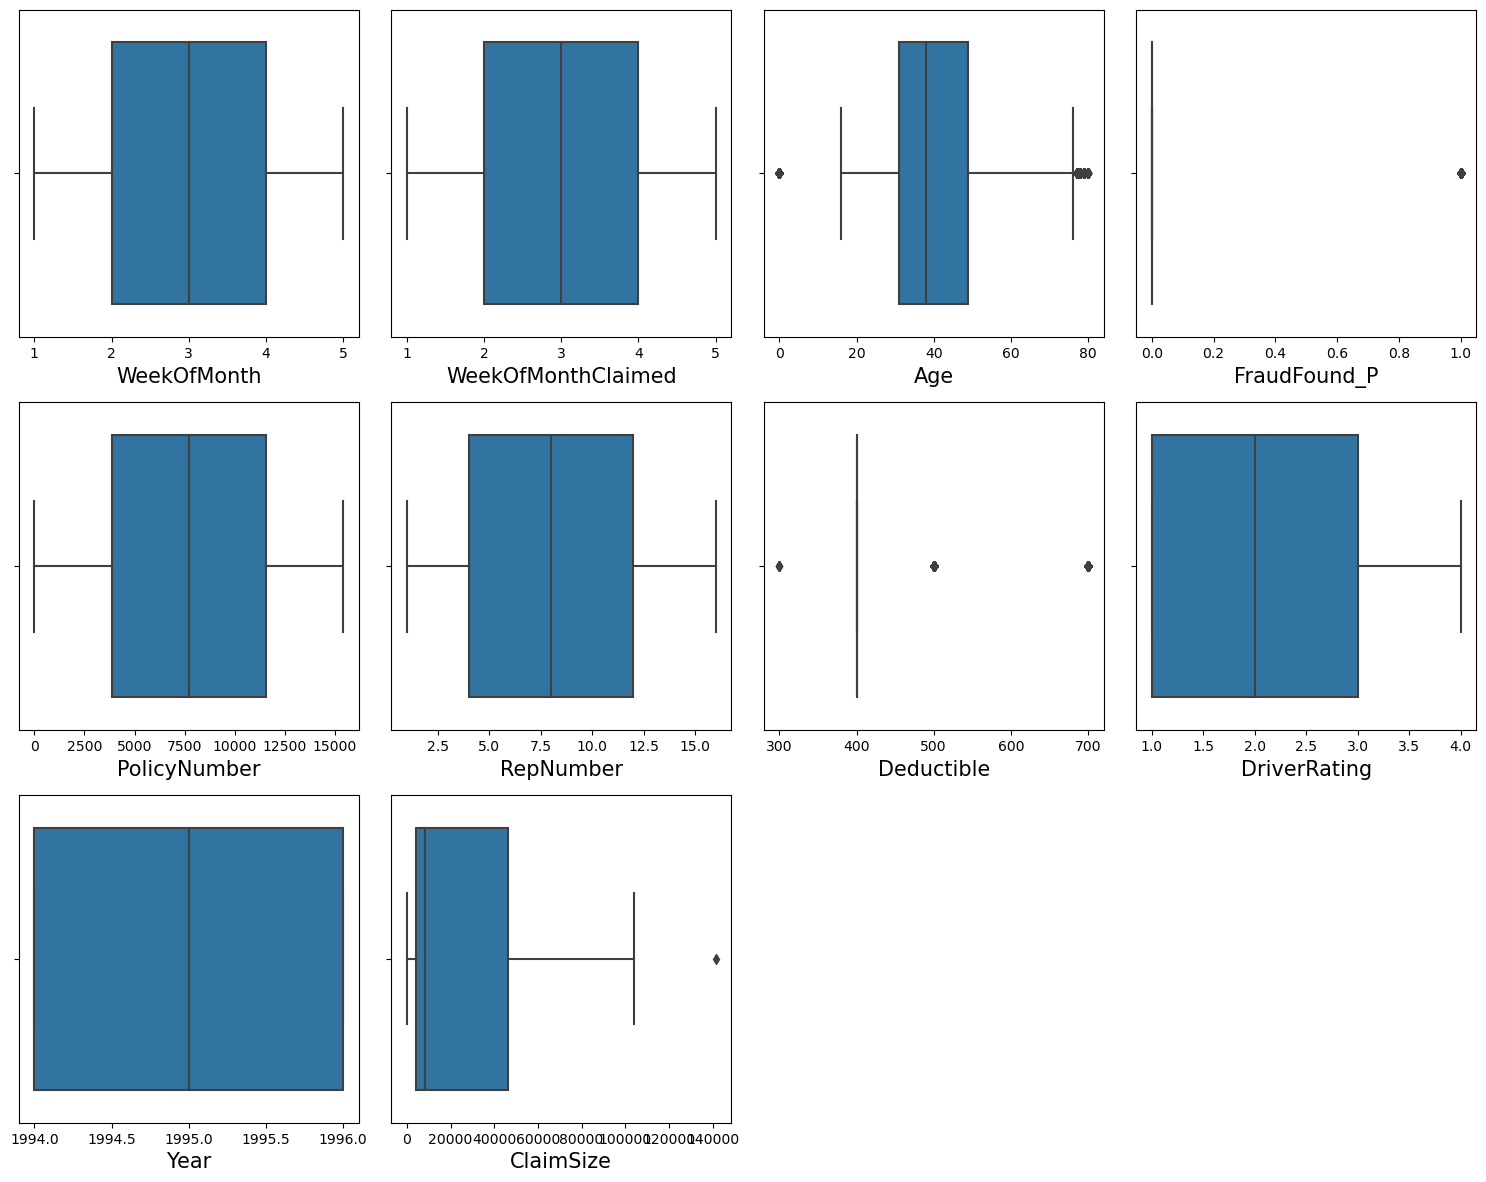

In [12]:
fig = plt.figure(figsize = (15, 35))
plotnumber = 1
for col in numeric_data:
    if plotnumber <= 34:
        ax = plt.subplot(9, 4, plotnumber)
        sns.boxplot(data=numeric_data,x=col)
        plt.xlabel(col, fontsize = 15)  
    plotnumber += 1
plt.tight_layout()
plt.show()
fig.savefig('Figures/Part 2/numeric_boxplots.png')

**FraudFound_P** and **Deductible** are categorical data and I don't intend to reduce the categories for these two columns.
**Age** and **ClaimSize** are numerical data. I don't want to remove the ouliers in Age column because Age follows a normal distribution and is naturally a noamalizerd feature (there is a bandwidth for it) showing some ages as outlier in our data is because of the bias in our data. <br>
But I'm more inteseted to investigate ClaimSize.

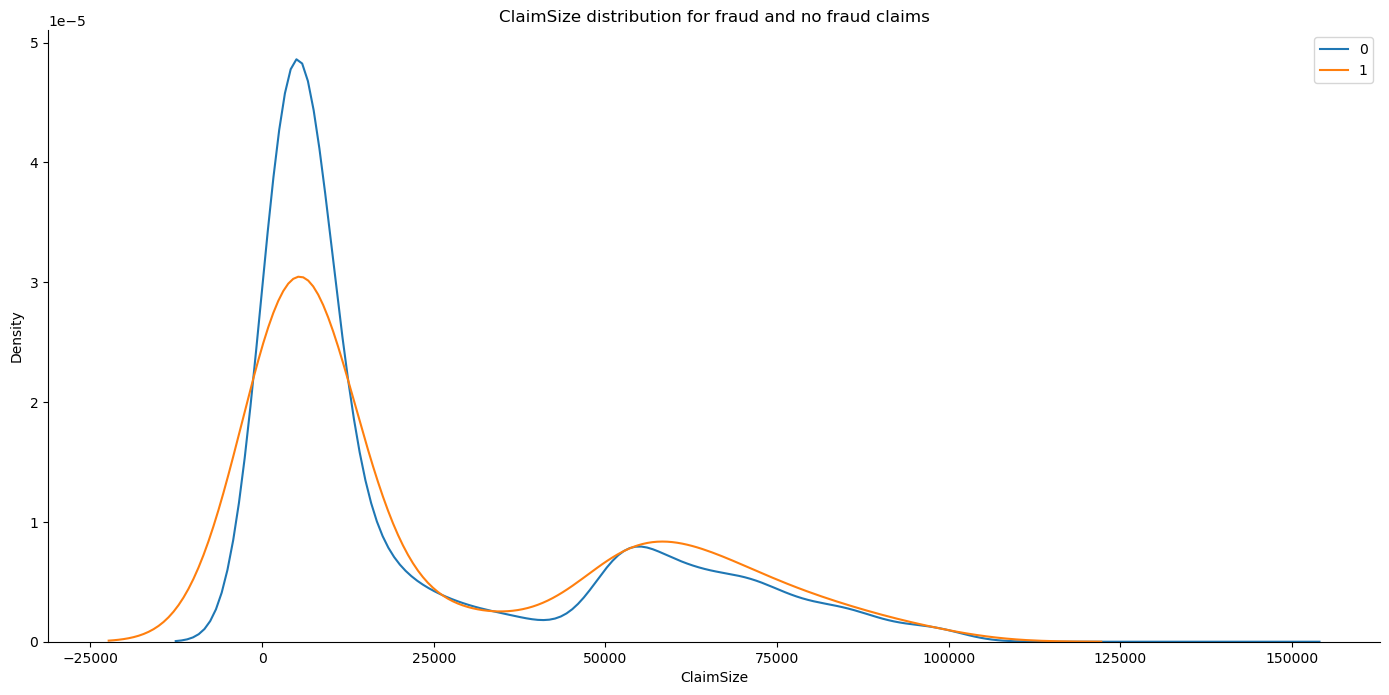

In [13]:
g = sns.FacetGrid(data, hue='FraudFound_P', height = 7, aspect = 2)
g.map(sns.kdeplot, 'ClaimSize')
plt.title('ClaimSize distribution for fraud and no fraud claims')
plt.legend()
plt.show()
g.savefig('Figures/Part 2/claim_size_dist.png')

In [14]:
iqr_ClaimSize = iqr(data["ClaimSize"])
Q3 = data["ClaimSize"].describe()["75%"]
boundry = Q3 + 1.5 * iqr_ClaimSize
boundry

110001.84067184542

In [15]:
data[data["ClaimSize"] > boundry]

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,ClaimSize
9985,Nov,3,Tuesday,Mazda,Urban,Wednesday,Nov,3,Female,Single,...,31 to 35,No,No,External,none,no change,1 vehicle,1996,Liability,141394.159289


We can see there is one claim size significantly larger than the others while not having any fraud. We better remove this row as 
it can worsen our model accuracy later and it doesn't include any meaningful or intersting information.

In [16]:
data = data.drop(data[data["ClaimSize"] > boundry].index)

In [17]:
data.to_csv('Data/Part2_data.csv')